In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [26]:
def feature_matching(img1, img2, savefig=False):
    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches2to1 = flann.knnMatch(des2,des1,k=2)

    matchesMask_ratio = [[0,0] for i in xrange(len(matches2to1))]
    match_dict = {}
    for i,(m,n) in enumerate(matches2to1):
        if m.distance < 0.7*n.distance:
            matchesMask_ratio[i]=[1,0]
            match_dict[m.trainIdx] = m.queryIdx

    good = []
    recip_matches = flann.knnMatch(des1,des2,k=2)
    matchesMask_ratio_recip = [[0,0] for i in xrange(len(recip_matches))]

    for i,(m,n) in enumerate(recip_matches):
        if m.distance < 0.7*n.distance: # ratio
            if m.queryIdx in match_dict and match_dict[m.queryIdx] == m.trainIdx: #reciprocal
                good.append(m)
                matchesMask_ratio_recip[i]=[1,0]



    if savefig:
        draw_params = dict(matchColor = (0,255,0),
                           singlePointColor = (255,0,0),
                           matchesMask = matchesMask_ratio_recip,
                           flags = 0)
        img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,recip_matches,None,**draw_params)

        plt.figure(),plt.xticks([]),plt.yticks([])
        plt.imshow(img3,)
        plt.savefig("feature_matching.png",bbox_inches='tight')

    return ([ kp1[m.queryIdx].pt for m in good ],[ kp2[m.trainIdx].pt for m in good ])

# Detect, extract and match features between img1 and img2.
# Using SIFT as the detector/extractor, but this is inconsequential to the user.

# Returns: (pts1, pts2), where ptsN are points on image N.
#     The lists are "aligned", i.e. point i in pts1 matches with point i in pts2.

# Usage example:
# im1 = cv2.imread("input1.png", 0)
# im2 = cv2.imread("input2.png", 0)
# (pts1, pts2) = feature_matching(im1, im2, savefig=True)
# plt.subplot(121)
# plt.imshow(im1)
# plt.scatter(pts1[:,:,0],pts1[:,:,1], 0.5, c='r', marker='x')
# plt.subplot(122)
# plt.imshow(im2)
# plt.scatter(pts1[:,:,0],pts1[:,:,1], 0.5, c='r', marker='x')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

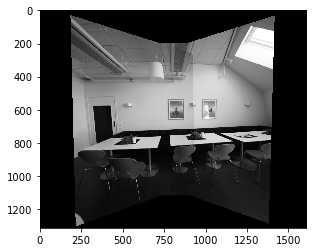

(1312, 1608)

In [168]:
def getTransform(src, dst, method='affine'):
    pts1,pts2 = feature_matching(src,dst)

    src_pts = np.float32(pts1).reshape(-1,1,2)
    dst_pts = np.float32(pts2).reshape(-1,1,2)

    if method == 'affine':
        M, mask = cv2.estimateAffine2D(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=5.0)
        M = np.append(M, [[0,0,1]], axis=0)

    if method == 'homography':
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    matchesMask = mask.ravel().tolist()

    return (M, pts1, pts2, mask)

# Calculate the geometric transform (only affine or homography) between two images,
# based on feature matching and alignment with a robust estimator (RANSAC).

# Returns: (M, pts1, pts2, mask)
# Where: M    is the 3x3 transform matrix
#        pts1 are the matched feature points in image 1
#        pts2 are the matched feature points in image 2
#        mask is a binary mask over the lists of points that selects the transformation inliers

im1 = cv2.imread("input1.png", 0)
im2 = cv2.imread("input2.png", 0)
im3 = cv2.imread("input3.png", 0)

im1 = cv2.copyMakeBorder(im1,200,200,500,500, cv2.BORDER_CONSTANT)
(M1, pts2, pts1, mask) = getTransform(im2, im1, method='homography')
out1 = cv2.warpPerspective(im2, M1, (im1.shape[1],im1.shape[0]), dst=im1.copy(), borderMode=cv2.BORDER_TRANSPARENT)

(M2, pts2, pts1, mask) = getTransform(im3, out1, method='homography')
out = cv2.warpPerspective(im3, M2, (im1.shape[1],im1.shape[0]), dst=out1.copy(), borderMode=cv2.BORDER_TRANSPARENT)

cv2.imwrite("out.png",out)
plt.imshow(out, cmap='gray')
plt.show()
out.shape

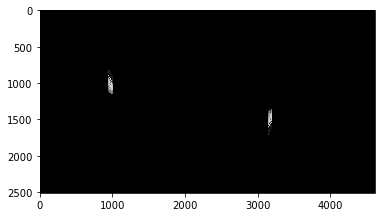

In [183]:
def cylindricalWarpImage(img1, K, savefig=False):
    f = K[0,0]

    im_h,im_w = img1.shape

    # go inverse from cylindrical coord to the image
    # (this way there are no gaps)
    cyl = np.zeros_like(img1)
    cyl_mask = np.zeros_like(img1)
    cyl_h,cyl_w = cyl.shape
    x_c = float(cyl_w) / 2.0
    y_c = float(cyl_h) / 2.0
    for x_cyl in np.arange(0,cyl_w):
        for y_cyl in np.arange(0,cyl_h):
            theta = (x_cyl - x_c) / f
            h     = (y_cyl - y_c) / f

            X = np.array([math.sin(theta), h, math.cos(theta)])
            X = np.dot(K,X)
            x_im = X[0] / X[2]
            if x_im < 0 or x_im >= im_w:
                continue

            y_im = X[1] / X[2]
            if y_im < 0 or y_im >= im_h:
                continue

            cyl[int(y_cyl),int(x_cyl)] = img1[int(y_im),int(x_im)]
            cyl_mask[int(y_cyl),int(x_cyl)] = 255


    if savefig:
        plt.imshow(cyl, cmap='gray')
        plt.savefig("cyl.png",bbox_inches='tight')

    return (cyl,cyl_mask)

# Warp an image from cartesian coordinates (x, y) into cylindrical coordinates (theta, h)
# Returns: (image, mask)
# Mask is [0,255], and has 255s wherever the cylindrical images has a valid value.
# Masks are useful for stitching

# Usage example:


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

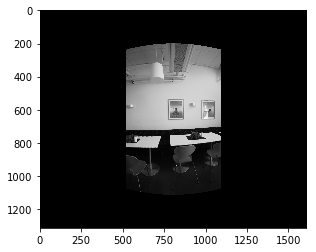

In [185]:
im1 = cv2.imread("input1.png",0) 
im2 = cv2.imread("input2.png",0) 
im3 = cv2.imread("input3.png",0) 

h,w = im1.shape
f = 700
K = np.array([[f, 0, w/2], [0, f, h/2], [0, 0, 1]]) # mock calibration matrix

cyl1, cyl_mask1 = cylindricalWarpImage(im1, K)
cyl1 = cv2.copyMakeBorder(cyl1,200,200,500,500, cv2.BORDER_CONSTANT)

plt.imshow(cyl1, cmap='gray')
plt.show()

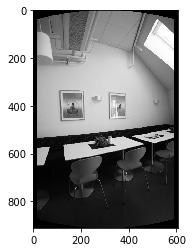

In [186]:
imcyl2 = cylindricalWarpImage(im2, K)
cyl2, cyl_mask2 = cylindricalWarpImage(im2, K)
plt.imshow(cyl2, cmap='gray')
plt.show()

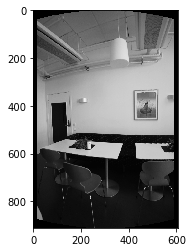

In [194]:
imcyl3 = cylindricalWarpImage(im3, K)
cyl3, cyl_mask3 = cylindricalWarpImage(im3, K)
plt.imshow(cyl3, cmap='gray')
plt.show()

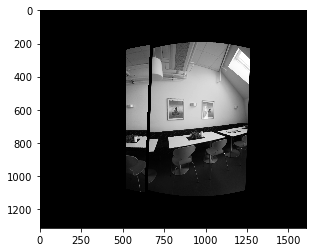

In [193]:
(M1, pts2, pts1, mask) = getTransform(cyl2, cyl1, method='affine')
out1 = cv2.warpPerspective(cyl2, M1, (cyl1.shape[1],cyl1.shape[0]), dst=cyl1.copy(), borderMode=cv2.BORDER_TRANSPARENT)

plt.imshow(out1, cmap='gray')
plt.show()

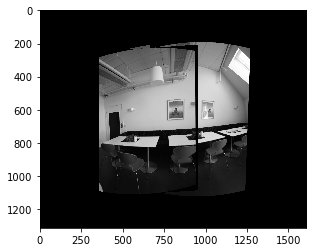

True

In [197]:
(M2, pts2, pts1, mask) = getTransform(cyl3, out1, method='affine')
out2 = cv2.warpPerspective(cyl3, M2, (cyl1.shape[1],cyl1.shape[0]), dst=out1.copy(), borderMode=cv2.BORDER_TRANSPARENT)

plt.imshow(out2, cmap='gray')
plt.show()

cv2.imwrite('out2.png',out2)